In [3]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import aefc_2dm as aefc
import adefc_vortex.fresnel_2dm as fresnel
import adefc_vortex.fraunhofer_2dm as fraunhofer

Nwaves = 9
wavelength_c = 650e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
est_waves = bandpasses[:, Nwaves_per_bp//2]
print(est_waves)

dm1_flat = xp.rot90(xp.rot90( utils.load_fits('dm1_flat_command.fits') ))

/home/kianmilani/Projects/adefc-vortex/adefc_vortex
[[6.17500e-07 6.25625e-07 6.33750e-07]
 [6.41875e-07 6.50000e-07 6.58125e-07]
 [6.66250e-07 6.74375e-07 6.82500e-07]]
[6.25625e-07 6.50000e-07 6.74375e-07]


/home/kianmilani/Projects/adefc-vortex/adefc_vortex


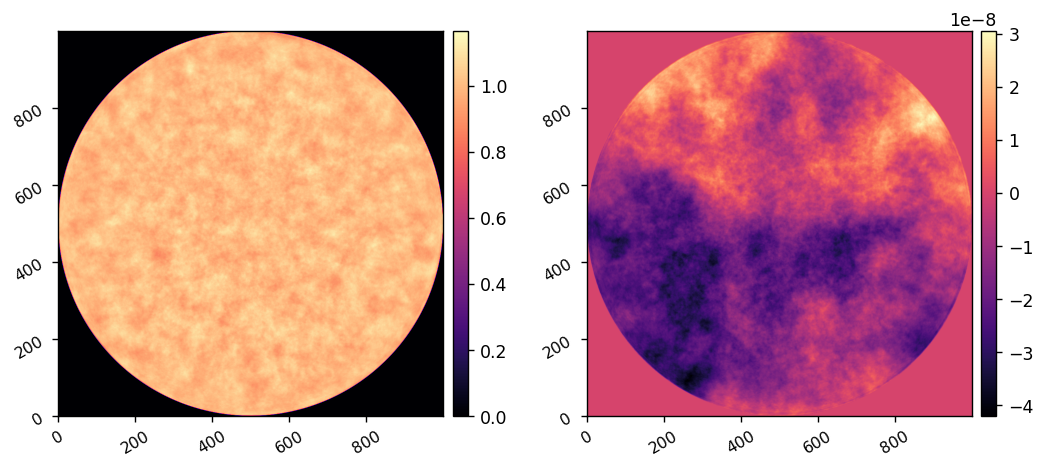

In [4]:
reload(fresnel)
I = fresnel.CORO(
    # dm1_ref=dm1_flat,
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


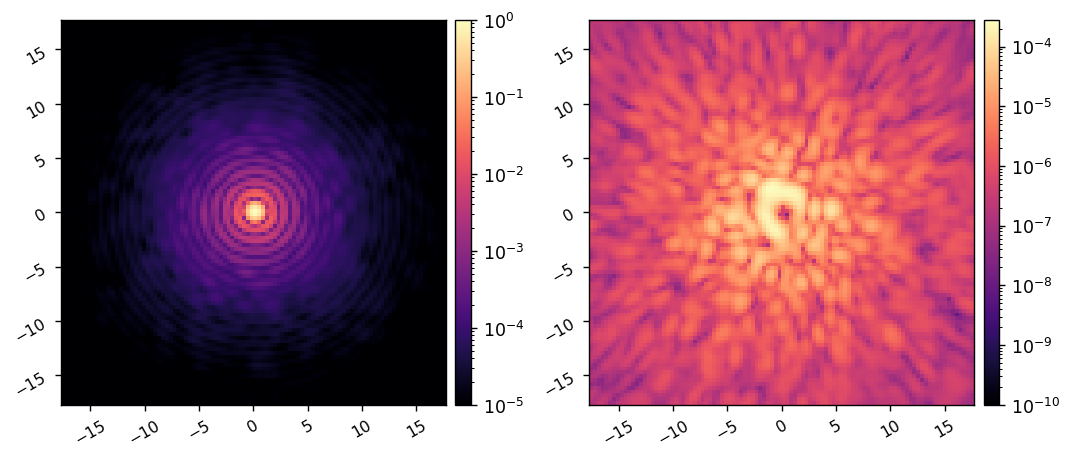

In [5]:
reload(fresnel)
I = fresnel.CORO(
        # dm1_ref=dm1_flat,
)
I.use_opds = True
I.bandpasses = bandpasses 

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


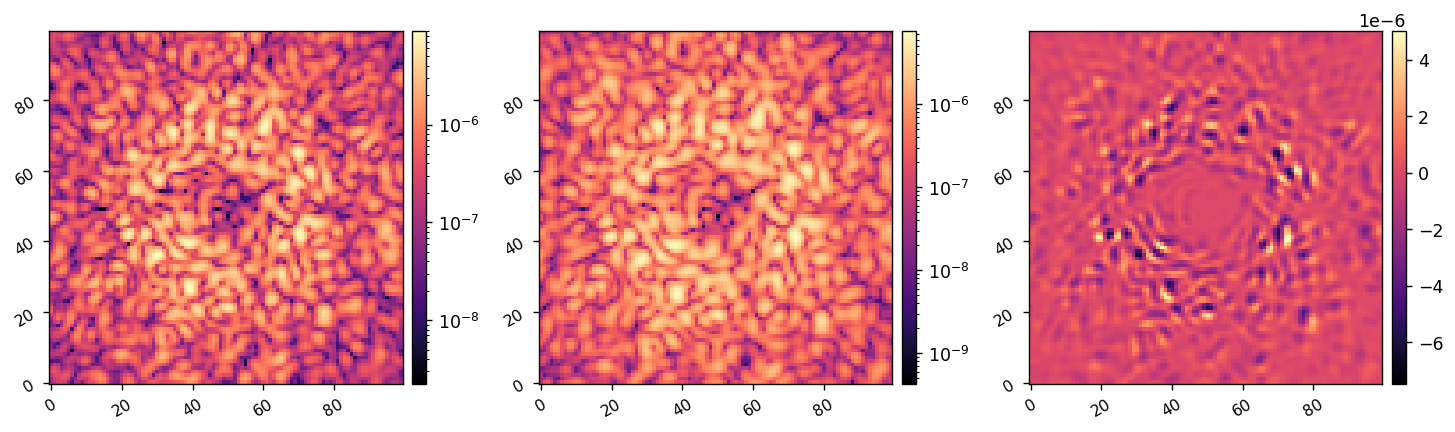

In [58]:
im_bp1 = I.snap(1)
im_bp3 = I.snap(3)
diff = im_bp3 - im_bp1
imshow3(im_bp1, im_bp3, diff, lognorm1=True, lognorm2=True, )

In [8]:
est_waves

array([6.25625e-07, 6.50000e-07, 6.74375e-07])

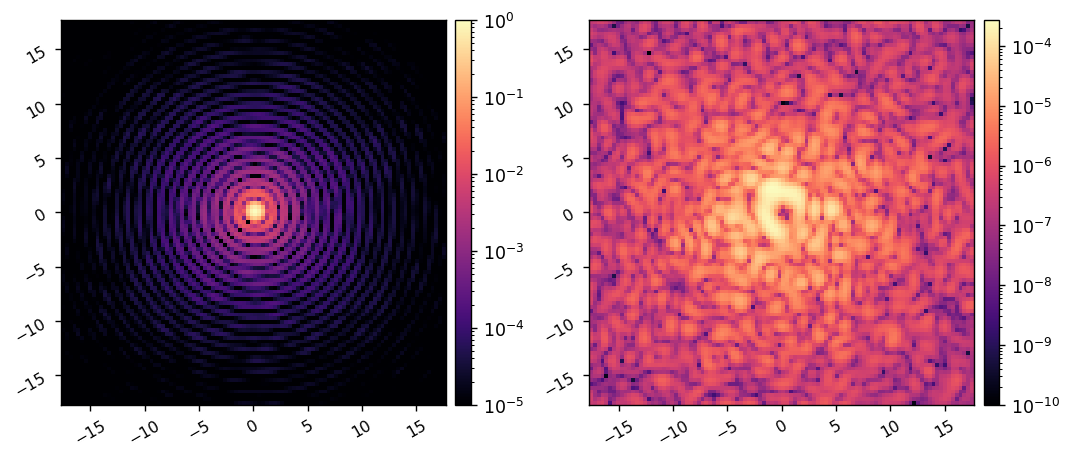

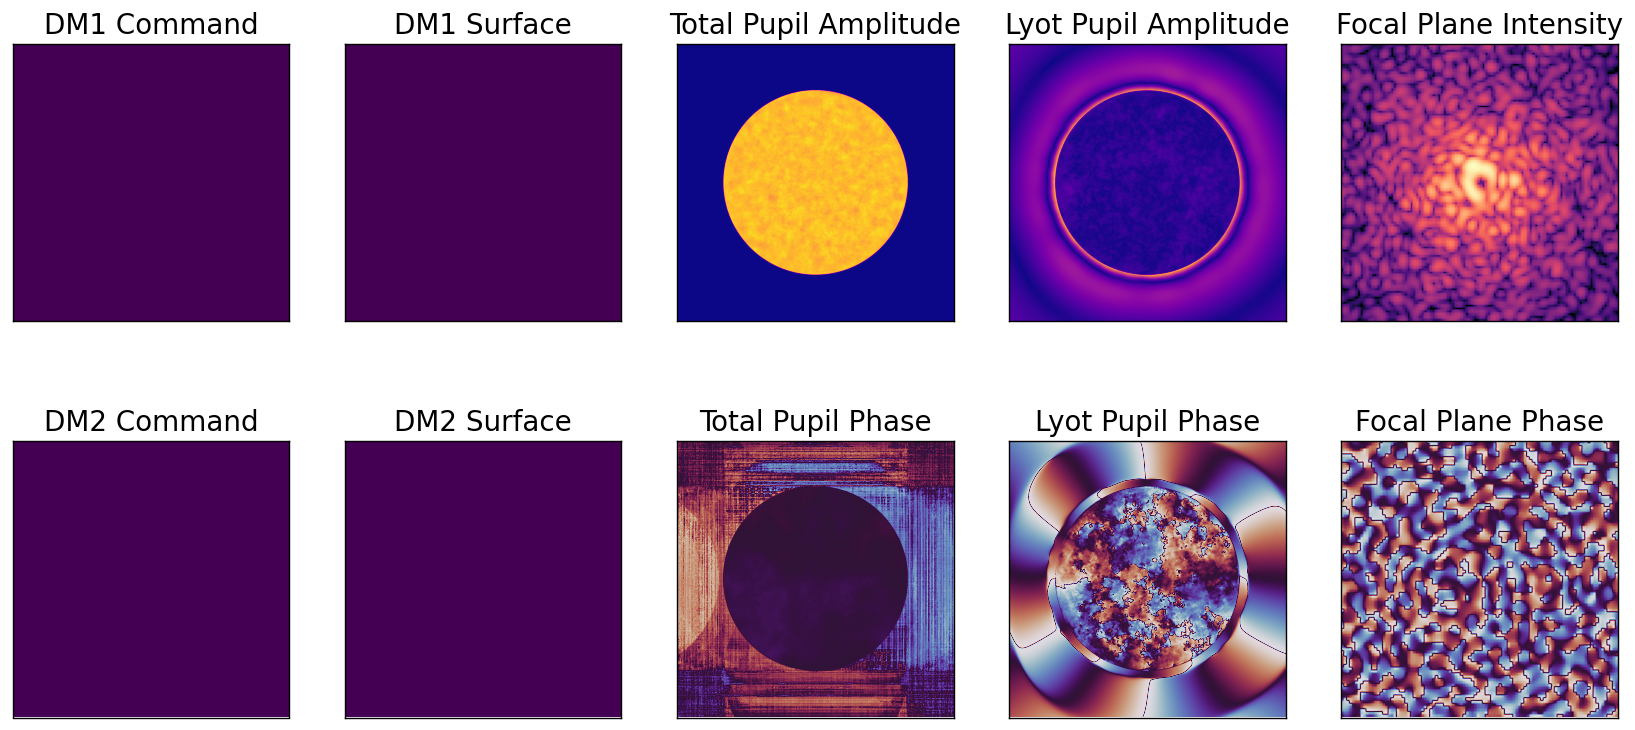

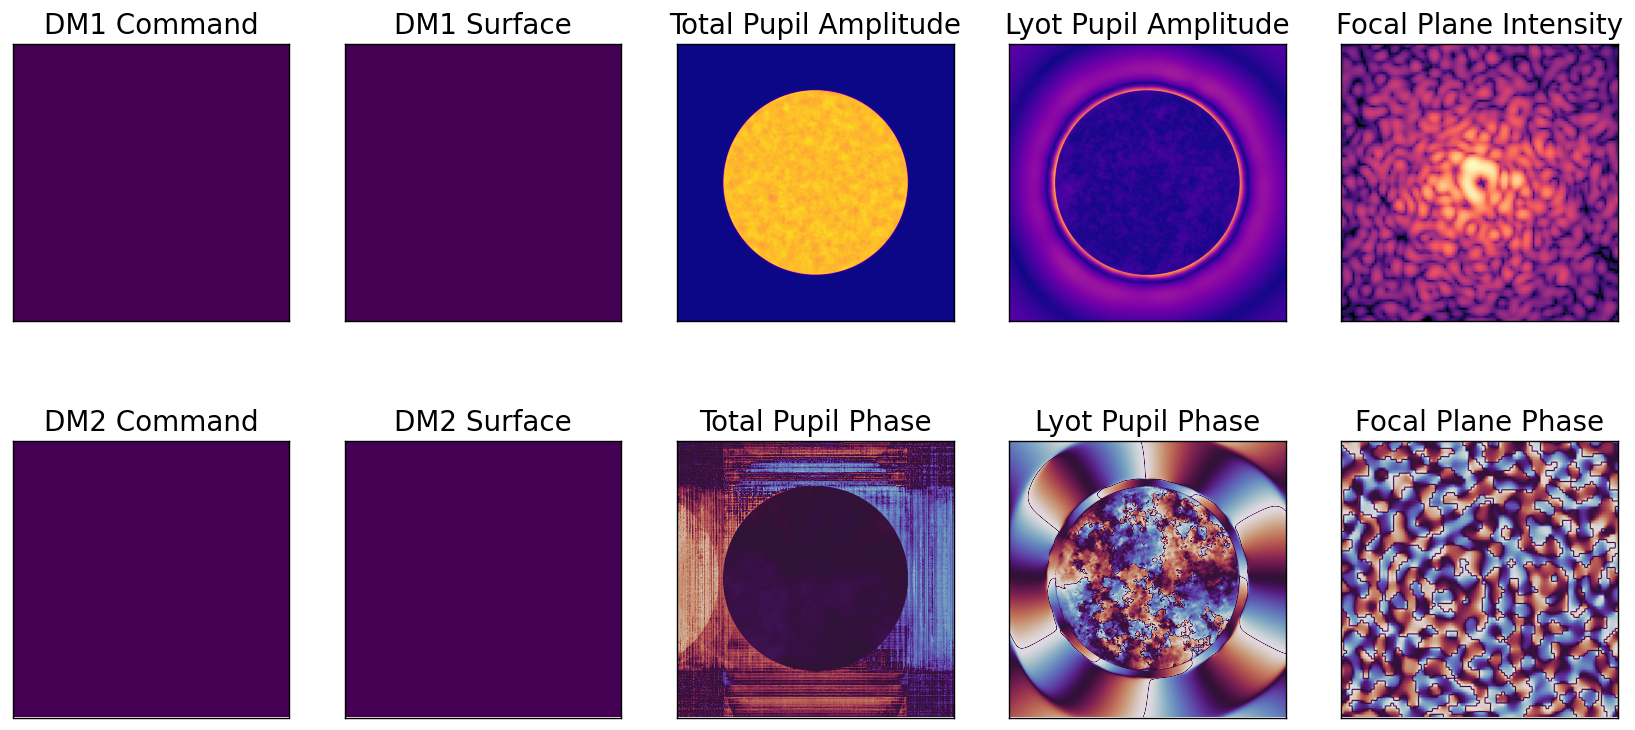

In [6]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

acts = xp.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=0) )**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

model_coro_im = xp.abs( M.forward(acts, M.wavelength_c, use_vortex=1) )**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
# dm1_command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
# dm1_command = 2.5e-9*utils.make_fourier_command(x_cpa=17, y_cpa=0)
# dm2_command = 2.5e-9*utils.make_fourier_command(x_cpa=0, y_cpa=17)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf_1 = M.forward(acts, est_waves[0], use_vortex=1, fancy_plot=1)
fpwf_2 = M.forward(acts, est_waves[-1], use_vortex=1, fancy_plot=1)

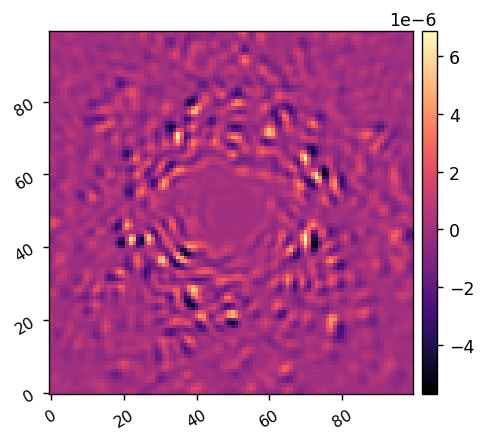

In [10]:
imshow1(xp.abs(fpwf_1)**2 - xp.abs(fpwf_2)**2)

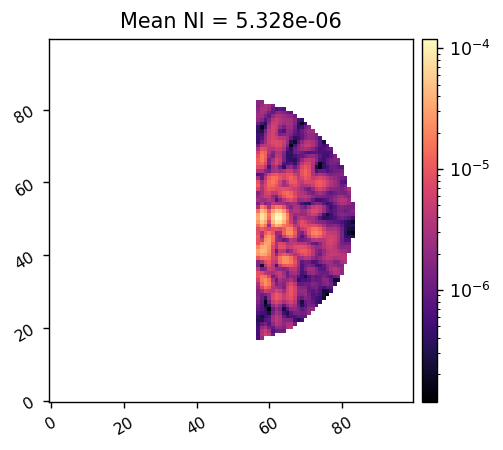

In [7]:
reload(utils)
I.reset_dms()
iwa = 2.5
owa = 12
rot = 0
# control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)

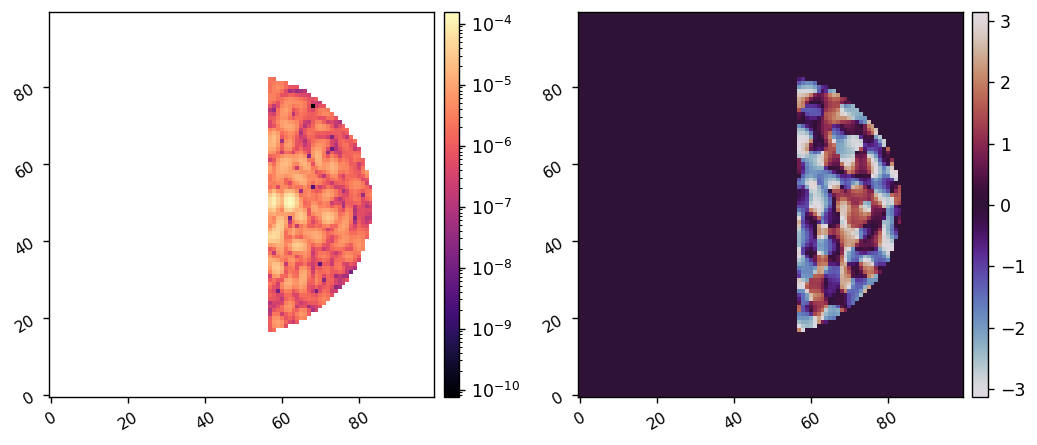

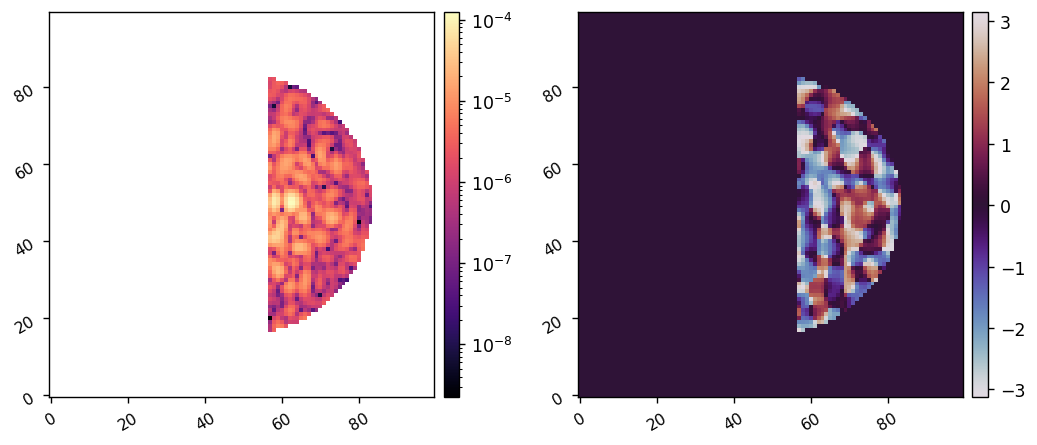

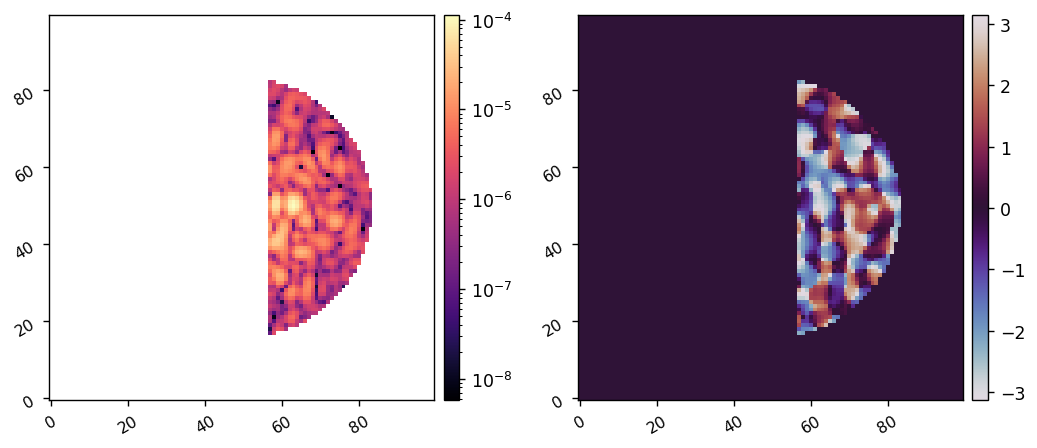

In [9]:
reload(aefc)
E_abs = aefc.calc_wfs(I, est_waves, control_mask, plot=1)


	Cost-function J_delE: 0.008
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.008
	Total cost-function value: 1.000

	Cost-function J_delE: 0.007
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.007
	Total cost-function value: 1.000

	Cost-function J_delE: 0.006
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 1.000



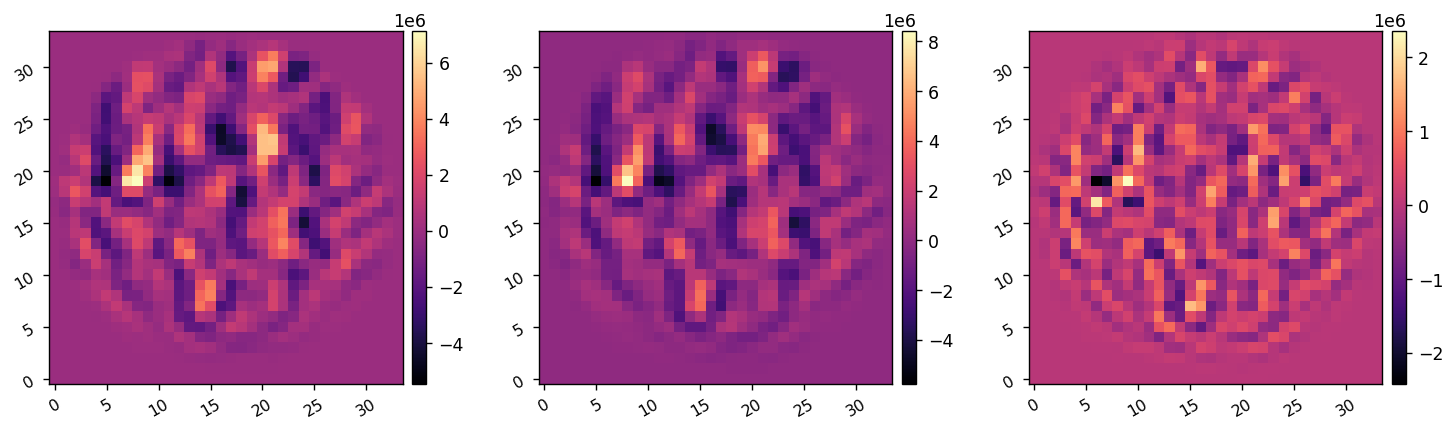

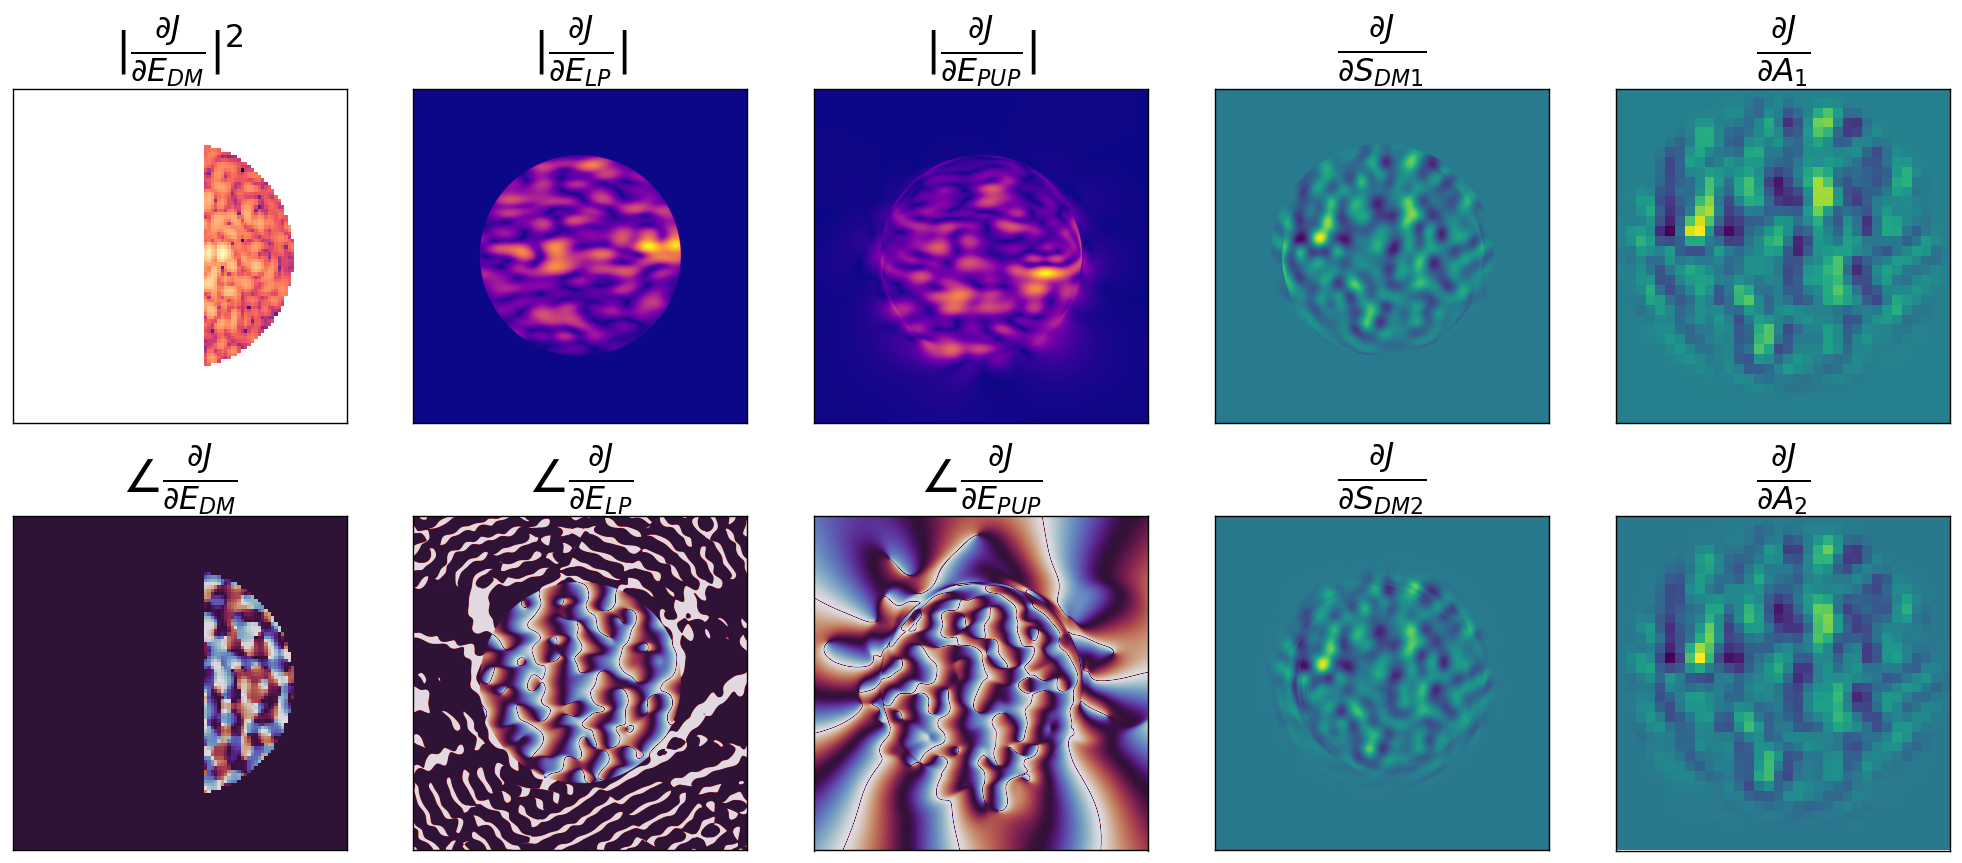

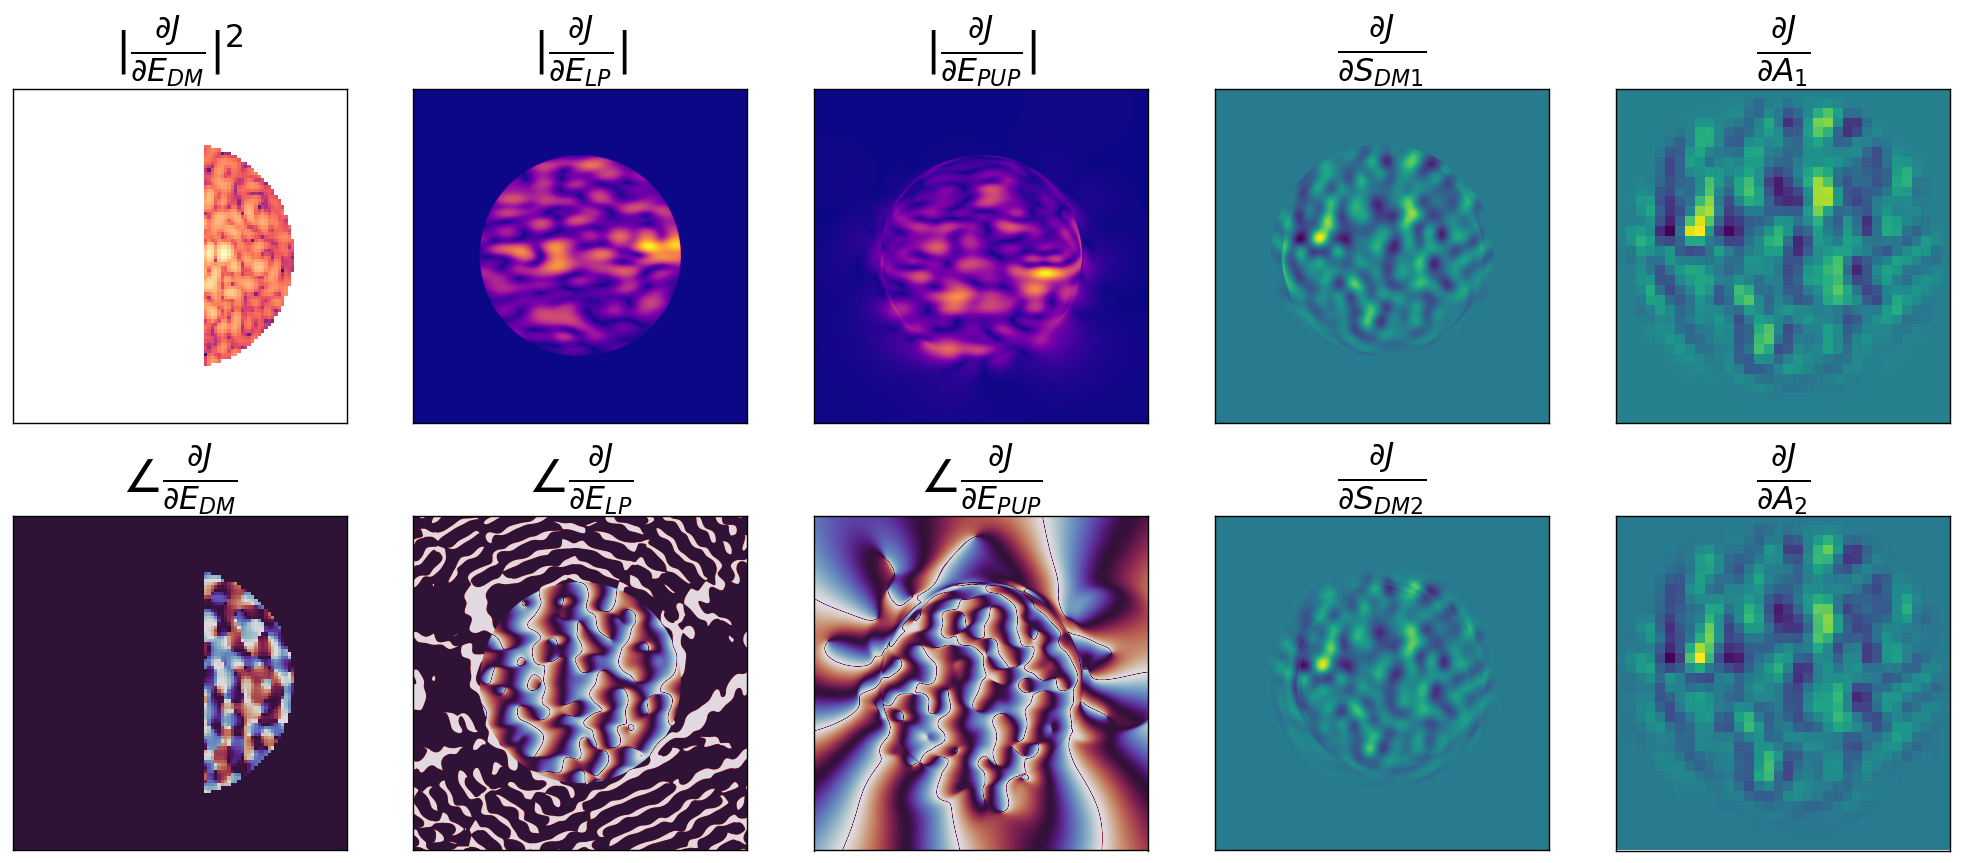

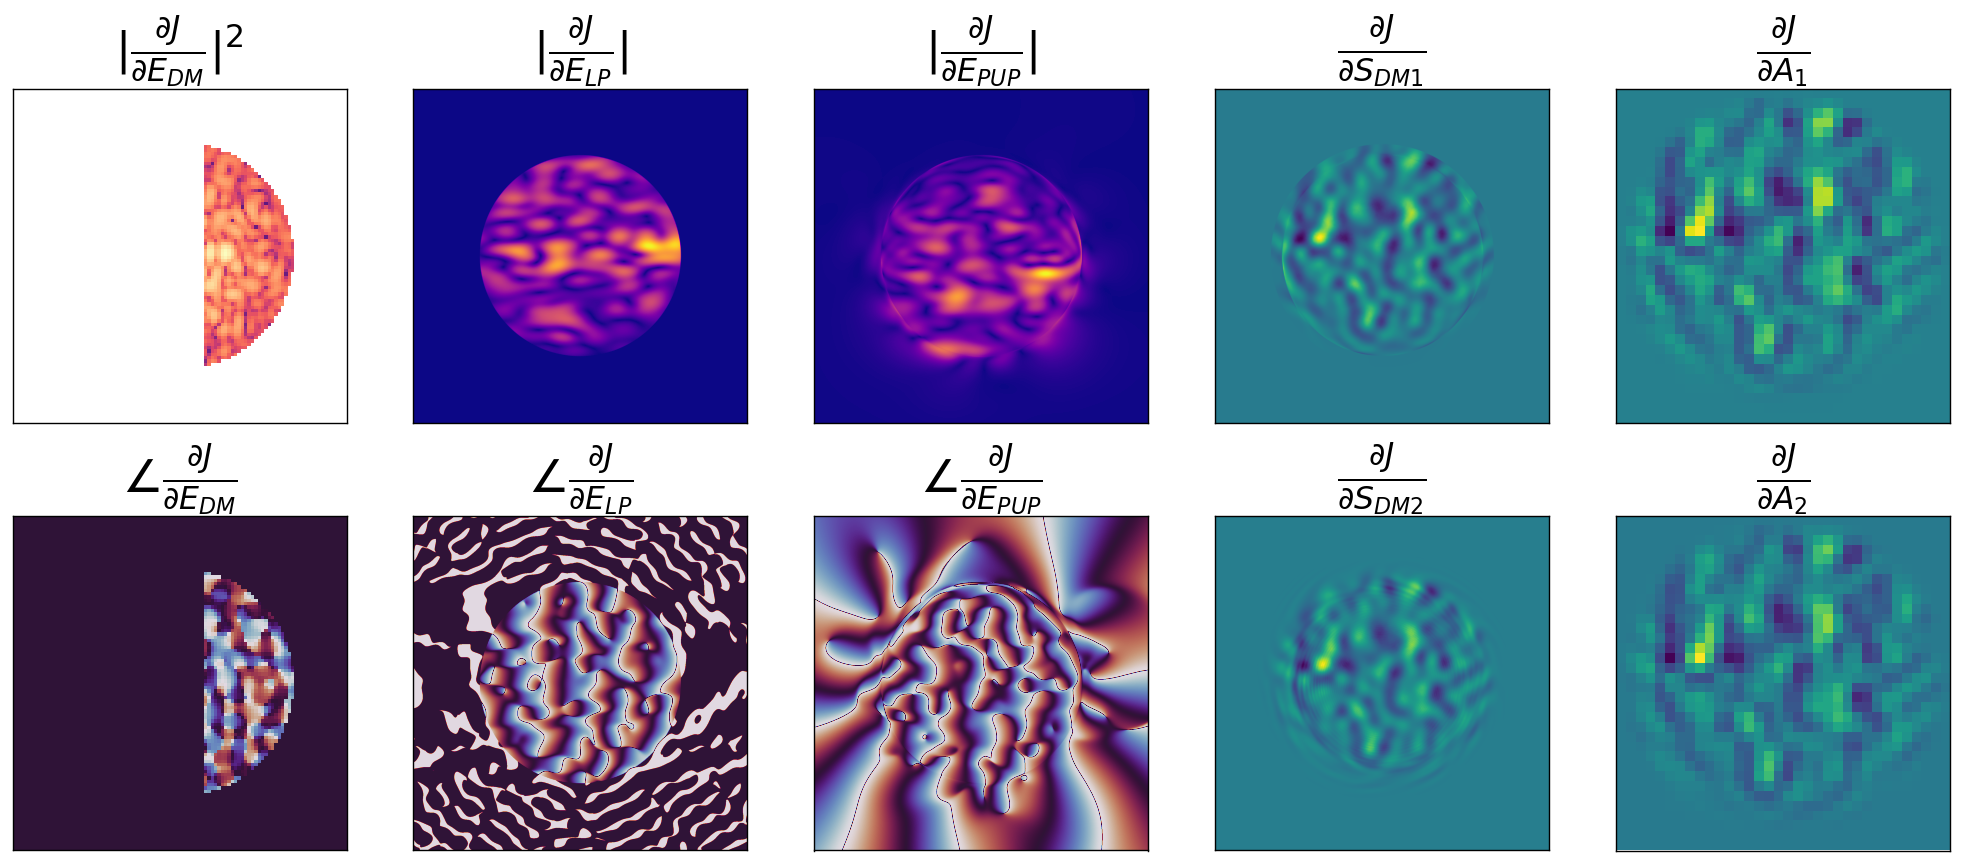

In [12]:
reload(fraunhofer)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('ad_test_acts.fits')

I.reset_dms()
I.add_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.add_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))

E_abs = aefc.calc_wfs(I, est_waves, control_mask, plot=0)
E_FP_NOMs, E_EPs, E_DM2Ps, DM1_PHASORs, DM2_PHASORs = aefc.get_forward_vars(M, current_acts, est_waves)

rmad_vars = { 
    'current_acts':current_acts,
    'E_abs':E_abs, 
    'E_FP_NOMs':E_FP_NOMs,
    'E_EPs':E_EPs,
    'E_DM2Ps':E_DM2Ps,
    'DM1_PHASORs':DM1_PHASORs,
    'DM2_PHASORs':DM2_PHASORs,
    'control_mask':control_mask,
    'control_waves':est_waves,
    'r_cond':1e-3,
    'weights':None,
    # 'weights':np.array([10,1,10]), 
}

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad_bb(
    del_acts, 
    M, rmad_vars, 
    verbose=True, 
    # plot=True, 
    fancy_plot=True,
)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

In [56]:
reload(fraunhofer)
reload(aefc)

current_acts = xp.zeros(M.Nacts)
# current_acts = fits.getdata('ad_test_acts.fits')

I.reset_dms()
I.add_dm1(fraunhofer.acts_to_command(current_acts[:M.Nacts//2], M.dm_mask))
I.add_dm2(fraunhofer.acts_to_command(current_acts[M.Nacts//2:], M.dm_mask))

E_abs = aefc.calc_wfs(I, est_waves, control_mask, plot=0)
E_FP_NOMs, E_EPs, E_DM2Ps, DM1_PHASORs, DM2_PHASORs = aefc.get_forward_vars(M, current_acts, est_waves)

rmad_vars = { 
    'current_acts':current_acts,
    'E_abs':E_abs, 
    'E_FP_NOMs':E_FP_NOMs,
    'E_EPs':E_EPs,
    'E_DM2Ps':E_DM2Ps,
    'DM1_PHASORs':DM1_PHASORs,
    'DM2_PHASORs':DM2_PHASORs,
    'control_mask':control_mask,
    'control_waves':est_waves,
    'r_cond':1e-3,
    'weights':None,
    # 'weights':np.array([10,1,10]), 
}

bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    fraunhofer.val_and_grad_bb, 
    jac=True, 
    x0=del_acts0,
    args=(M, rmad_vars, True, False), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


	Cost-function J_delE: 0.008
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.008
	Total cost-function value: 1.000

	Cost-function J_delE: 0.007
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.007
	Total cost-function value: 1.000

	Cost-function J_delE: 0.006
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  8.40541D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.008
	Total cost-function value: 0.072



 This problem is unconstrained.


	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.007
	Total cost-function value: 0.065

	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 0.066

	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.008
	Total cost-function value: 0.077

	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.007
	Total cost-function value: 0.075

	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 0.063

	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.008
	Total cost-function value: 0.076

	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.007
	Total cost-function value: 0.082

	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function

5.3282015852336526e-06 1.1159327793452625e-07


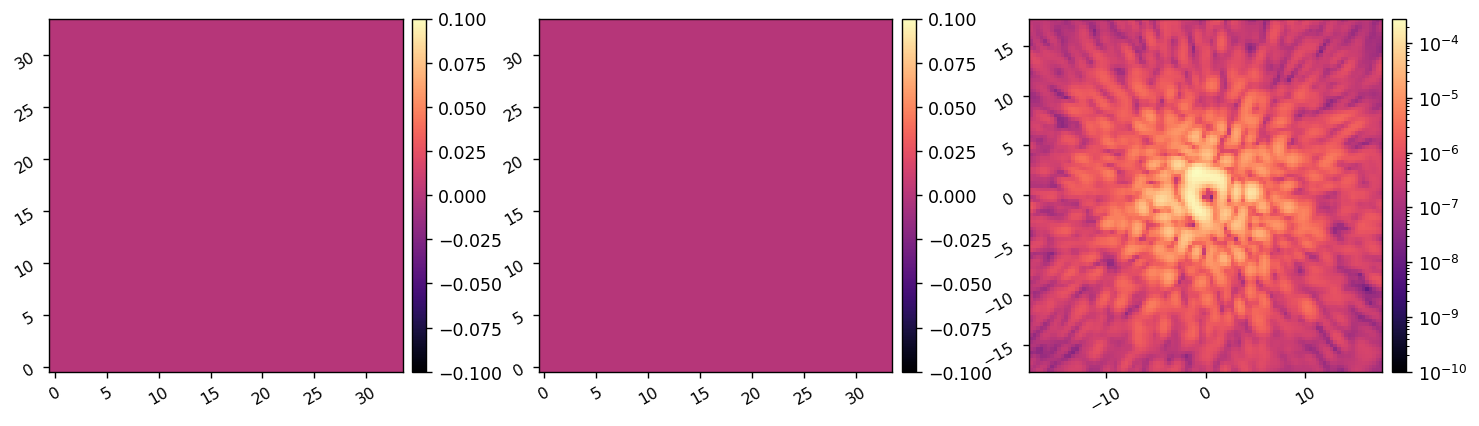

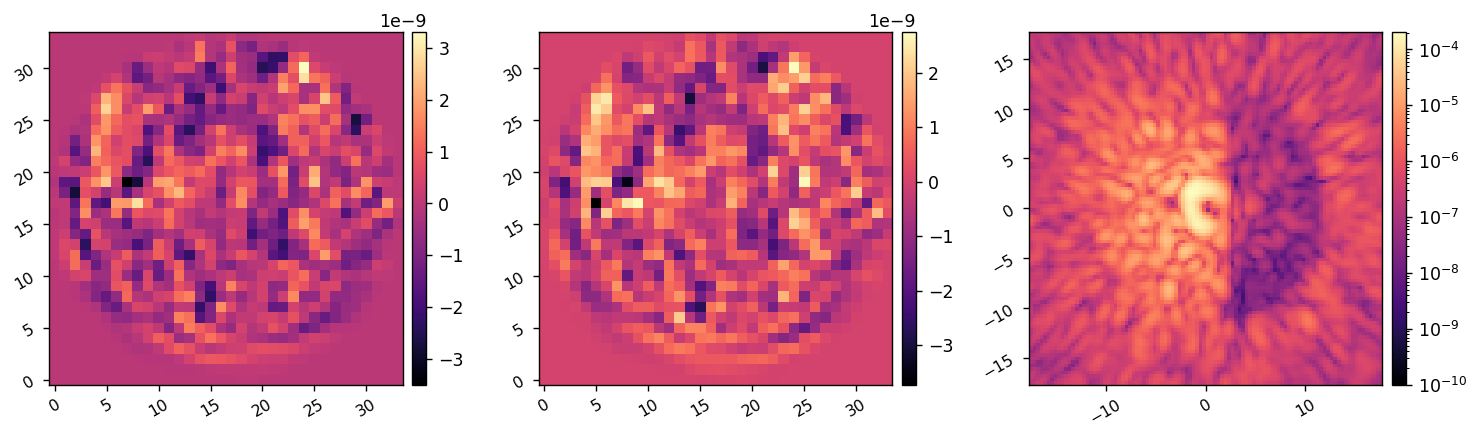

In [57]:
I.reset_dms()
old_dm1 = I.get_dm1()
old_dm2 = I.get_dm2()
old_im = I.snap()

del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)
I.add_dm1(del_dm1)
I.add_dm2(del_dm2)
new_im = I.snap()

print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, old_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [63]:
I.reset_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Computing E-field with model ...
Computing EFC command with L-BFGS


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  4.82810D+07

At iterate    1    f=  9.99772D-01    |proj g|=  5.56164D+07

At iterate    2    f=  9.99567D-01    |proj g|=  3.49074D+07

At iterate    3    f=  9.98983D-01    |proj g|=  4.04722D+07

At iterate    4    f=  9.98331D-01    |proj g|=  6.21072D+07

At iterate    5    f=  9.97327D-01    |proj g|=  5.67240D+07

At iterate    6    f=  9.96573D-01    |proj g|=  1.01755D+08

At iterate    7    f=  9.95185D-01    |proj g|=  4.35900D+07

At iterate    8    f=  9.93860D-01    |proj g|=  4.39143D+07

At iterate    9    f=  9.92782D-01    |proj g|=  7.13407D+07

At iterate   10    f=  9.91907D-01    |proj g|=  5.56270D+07

At iterate   11    f=  9.91196D-01    |proj g|=  3.48935D+07

At iterate   12    f=  9.90712D-01    |proj g|=  3.01630D+07

At iterate   13    f=  9.9

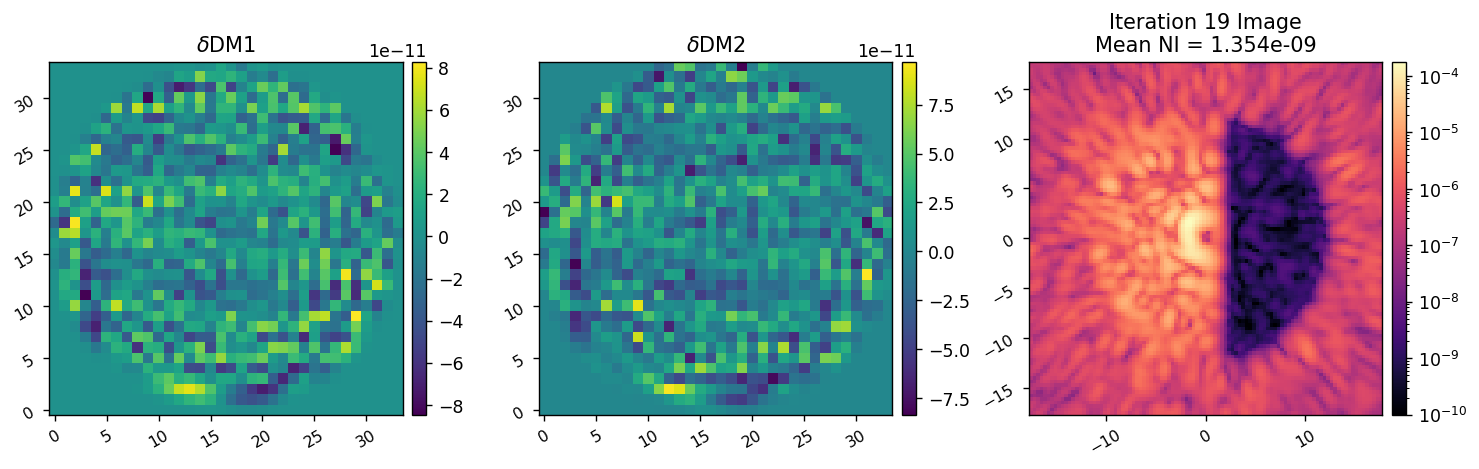

Computing E-field with model ...
Computing EFC command with L-BFGS


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  6.55344D+08

At iterate    1    f=  9.56958D-01    |proj g|=  3.33561D+08

At iterate    2    f=  9.47141D-01    |proj g|=  1.76988D+08

At iterate    3    f=  9.42255D-01    |proj g|=  9.98789D+07

At iterate    4    f=  9.40217D-01    |proj g|=  9.28954D+07

At iterate    5    f=  9.38663D-01    |proj g|=  5.91692D+07

At iterate    6    f=  9.37405D-01    |proj g|=  4.82754D+07

At iterate    7    f=  9.36535D-01    |proj g|=  7.15897D+07

At iterate    8    f=  9.35674D-01    |proj g|=  4.63464D+07

At iterate    9    f=  9.34926D-01    |proj g|=  3.78557D+07

At iterate   10    f=  9.34042D-01    |proj g|=  5.67194D+07

At iterate   11    f=  9.33290D-01    |proj g|=  6.71642D+07

At iterate   12    f=  9.32679D-01    |proj g|=  3.72904D+07

At iterate   13    f=  9.3

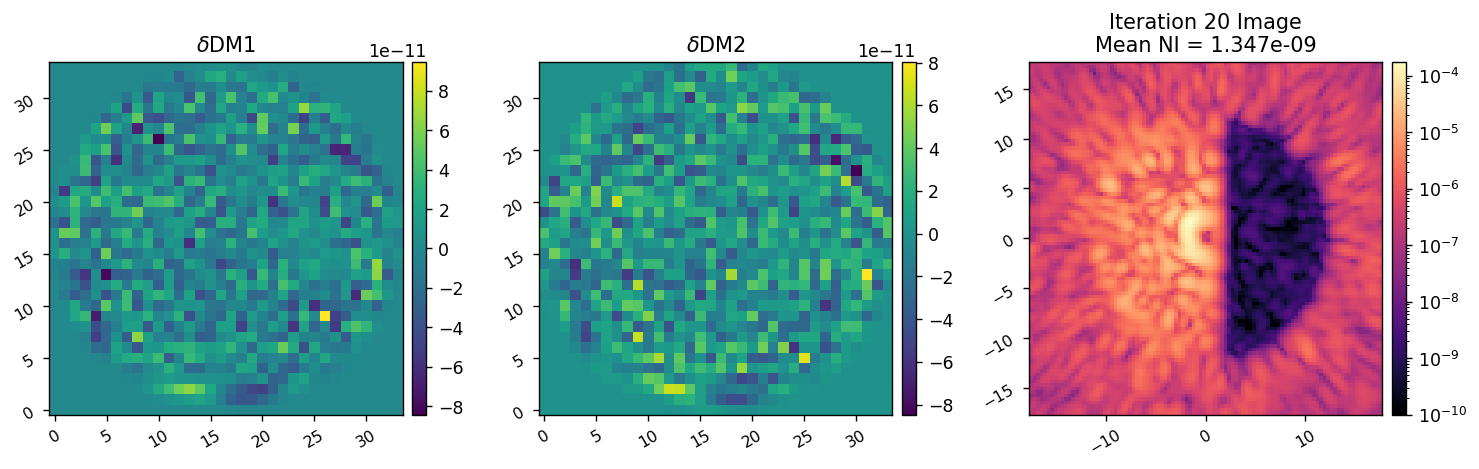

Computing E-field with model ...
Computing EFC command with L-BFGS


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  6.92447D+08

At iterate    1    f=  9.63548D-01    |proj g|=  3.02474D+08

At iterate    2    f=  9.54971D-01    |proj g|=  1.47138D+08

At iterate    3    f=  9.51585D-01    |proj g|=  9.60155D+07

At iterate    4    f=  9.49581D-01    |proj g|=  7.96494D+07

At iterate    5    f=  9.48228D-01    |proj g|=  9.20926D+07

At iterate    6    f=  9.47292D-01    |proj g|=  4.25193D+07

At iterate    7    f=  9.46573D-01    |proj g|=  4.20297D+07

At iterate    8    f=  9.45955D-01    |proj g|=  5.25569D+07

At iterate    9    f=  9.45302D-01    |proj g|=  6.41305D+07

At iterate   10    f=  9.44751D-01    |proj g|=  3.94523D+07

At iterate   11    f=  9.44281D-01    |proj g|=  3.87327D+07

At iterate   12    f=  9.43835D-01    |proj g|=  3.81506D+07

At iterate   13    f=  9.4

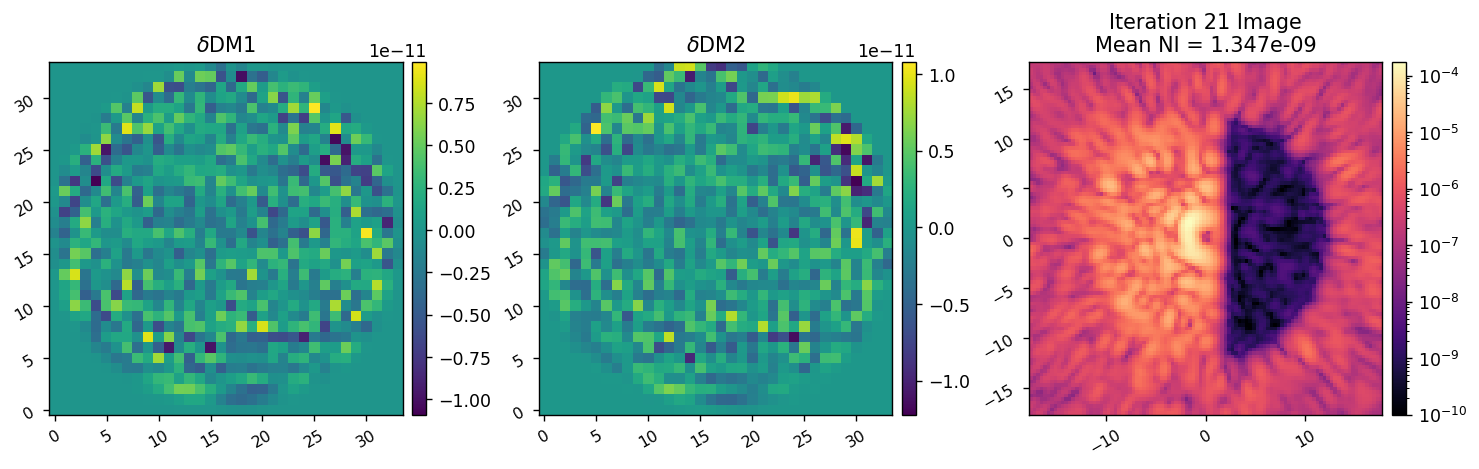

In [70]:
reload(fraunhofer)
reload(aefc)

r_cond = 1e4
# r_cond = 1e3
# r_cond = 100
# r_cond = 10
# r_cond = 1
r_cond = 1e-1
# r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6
# r_cond = 1e-7
# r_cond = 1e-8
# r_cond = 1e-9
# r_cond = 1e-10
# r_cond = 1e-11
r_cond = 1e-12
# r_cond = 0

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    'maxls':100, 
    'maxiter':100,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = aefc.run_bb(
    I, 
    M, 
    fraunhofer.val_and_grad_bb, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    # weights=np.array([20,1,20]), 
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)



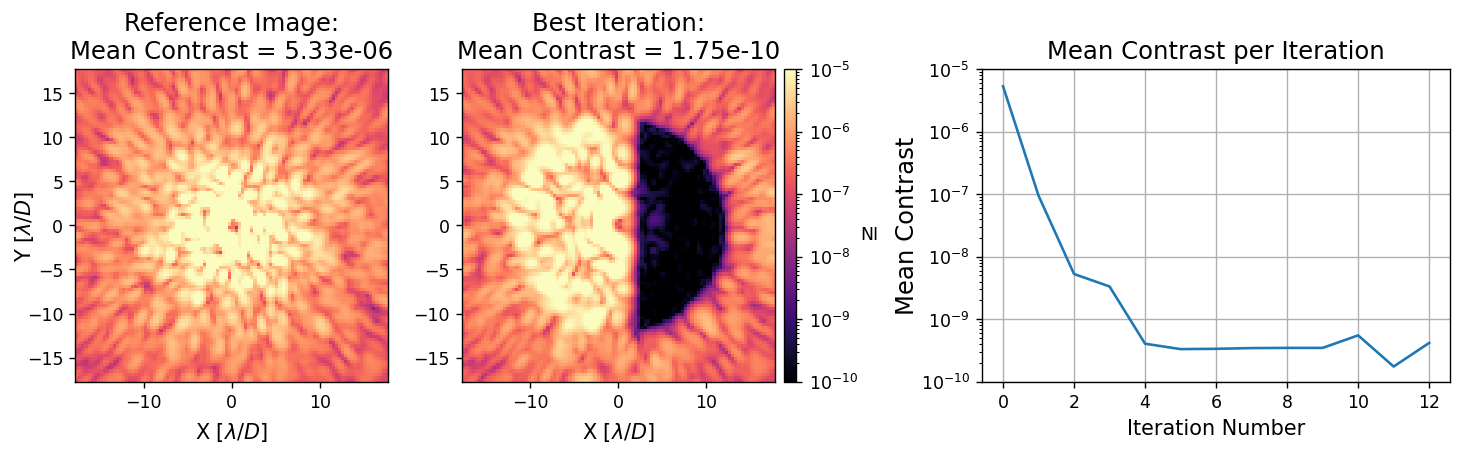

In [22]:
plot_data(data, imvmin=1e-10, imvmax=1e-5, vmin=1e-10, vmax=1e-5)

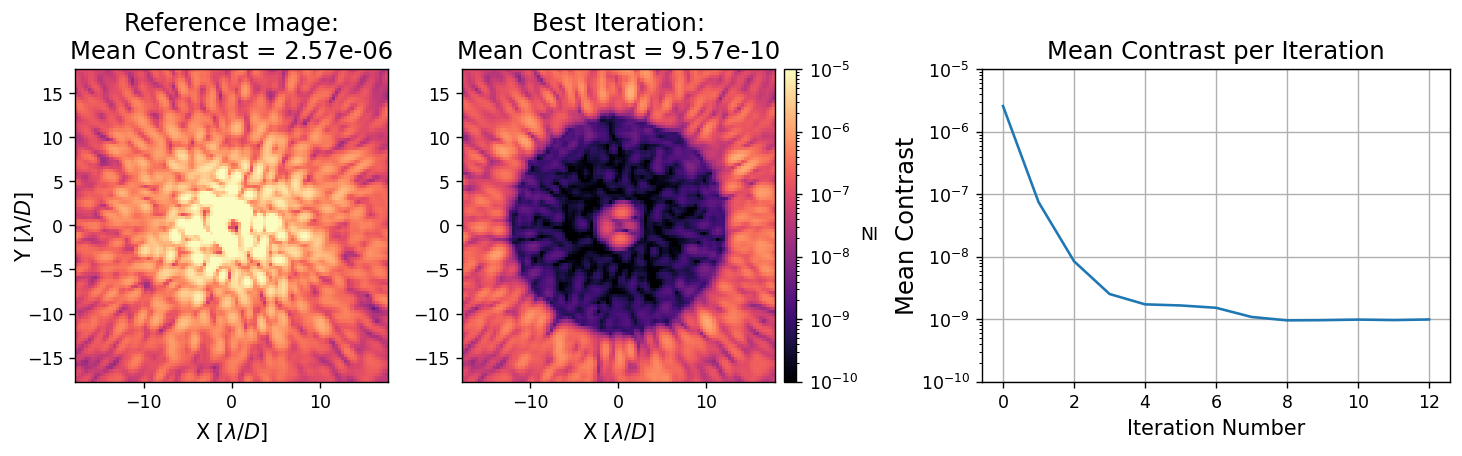

In [42]:
plot_data(data, vmin=1e-10, vmax=1e-5)

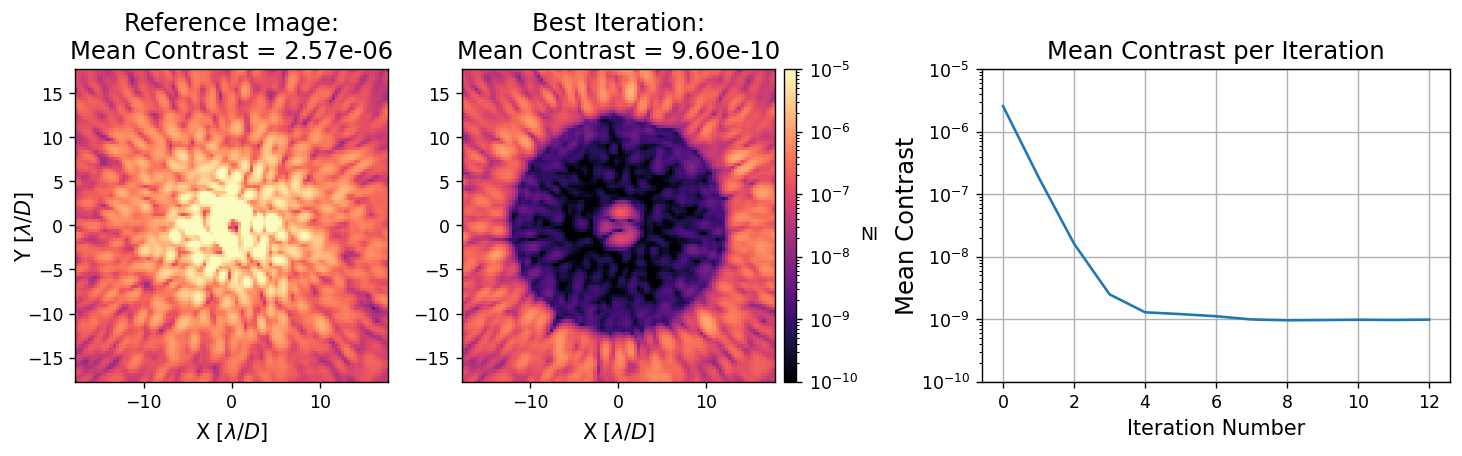

In [35]:
plot_data(data, vmin=1e-10, vmax=1e-5)